In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import IPython
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import time
from tqdm import tqdm
import tensorflow as tf

from nara_wpe.tf_wpe import wpe
from nara_wpe.tf_wpe import online_wpe_step, get_power_online
from nara_wpe.utils import stft, istft, get_stft_center_frequencies
from nara_wpe import project_root

/home/danielha/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
stft_options = dict(
    size=512,
    shift=128,
    window_length=None,
    fading=True,
    pad=True,
    symmetric_window=False
)

# Example with real audio recordings
The iterations are dropped in contrast to the offline version. To use past observations the correlation matrix and the correlation vector are calculated recursively with a decaying window. $\alpha$ is the decay factor.

### Setup

In [3]:
channels = 8
sampling_rate = 16000
delay = 3
alpha=0.99
K = 10
frequency_bins = stft_options['size'] // 2 + 1

### Audio data

In [4]:
file_template = 'AMI_WSJ20-Array1-{}_T10c0201.wav'
signal_list = [
    sf.read(str(project_root / 'data' / file_template.format(d + 1)))[0]
    for d in range(channels)
]
y = np.stack(signal_list, axis=0)
IPython.display.Audio(y[0], rate=sampling_rate)

### Online buffer
For simplicity the STFT is performed before providing the frames.

Shape: (frames, frequency bins, channels)

frames: K+delay+1

In [5]:
Y = stft(y, **stft_options).transpose(1, 2, 0)
T, _, _ = Y.shape

def aquire_framebuffer():
    buffer = list(Y[:K+delay+1, :, :])
    for t in range(K+delay+1, T):
        yield np.array(buffer)
        buffer.append(Y[t, :, :])
        buffer.pop(0)

### Non-iterative frame online approach
A frame online example requires, that certain state variables are kept from frame to frame. That is the inverse correlation matrix $\text{R}_{t, f}^{-1}$ which is stored in Q and initialized with an identity matrix, as well as filter coefficient matrix that is stored in G and initialized with zeros. 

Again for simplicity the ISTFT is applied in Numpy afterwards.

In [6]:
Z_list = []

Q = np.stack([np.identity(channels * K) for a in range(frequency_bins)])
G = np.zeros((frequency_bins, channels * K, channels))

with tf.Session() as session:
    Y_tf = tf.placeholder(tf.complex128, shape=(K + delay + 1, frequency_bins, channels))
    Q_tf = tf.placeholder(tf.complex128, shape=(frequency_bins, channels * K, channels * K))
    G_tf = tf.placeholder(tf.complex128, shape=(frequency_bins, channels * K, channels))
    
    results = online_wpe_step(Y_tf, get_power_online(Y_tf), Q_tf, G_tf, alpha=alpha, K=K, delay=delay)
    for Y_step in tqdm(aquire_framebuffer()):
        feed_dict = {Y_tf: Y_step, Q_tf: Q, G_tf: G}
        Z, Q, G = session.run(results, feed_dict)
        Z_list.append(Z)

Z_stacked = np.stack(Z_list)
z = istft(np.asarray(Z_stacked).transpose(2, 0, 1), size=stft_options['size'], shift=stft_options['shift'])

IPython.display.Audio(z[0], rate=sampling_rate)

985it [00:46, 21.24it/s]


# Power spectrum
Before and after applying WPE.

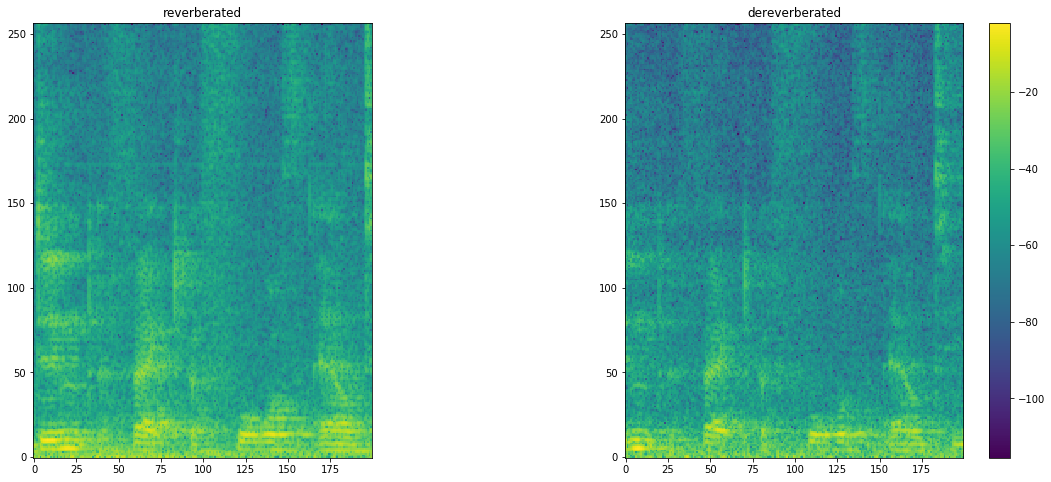

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 8))
im1 = ax1.imshow(20 * np.log10(np.abs(Y[200:400, :, 0])).T, origin='lower')
ax1.set_xlabel('')
_ = ax1.set_title('reverberated')
im2 = ax2.imshow(20 * np.log10(np.abs(Z_stacked[200:400, :, 0])).T, origin='lower')
_ = ax2.set_title('dereverberated')
cb = fig.colorbar(im1)